In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle

# custom classes for cross validation and scoring
import cross_validation
import performance_metrics

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv(r"../data/processed_data/complete_data.csv", index_col=0)


In [4]:
# split into features
x = data.drop(["TARGET"], axis=1)
y = data.filter(["TARGET"], axis=1)
y = y.values.reshape(y.shape[0])

# split dataset for hyperparameter tuning and kfold
split = 0.5
hp_x, hp_y = x[:int(len(x) * split)], y[:int(len(y) * split)] # hyperparameter set
kf_x, kf_y = x[int(len(x) * split):], y[int(len(y) * split):] # kfold set

hp_x.shape, hp_y.shape, kf_x.shape, kf_y.shape


((282686, 202), (282686,), (282686, 202), (282686,))

In [5]:
# scale the data for hyperparameter tuning
scaler = StandardScaler()
hp_x = scaler.fit_transform(hp_x)

In [13]:
def model_builder(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Int("n_est", min_value=200, max_value=600, step=100),
        max_depth=hp.Int("max_depth", min_value=10, max_value=50, step=10),
        min_samples_leaf=hp.Choice("min_samples_leaf", [1, 2, 4]),
        min_samples_split=hp.Choice("min_samples_split", [3, 5, 8])
    )
    
    return model

In [14]:
project_name = "rf_v1"

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective("score", "max"),
        max_trials=20
    ),
    hypermodel=model_builder,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=KFold(2, shuffle=True, random_state=7243),
    directory=f"../logs/rf/{project_name}",
    project_name=project_name   
)

INFO:tensorflow:Reloading Tuner from ../logs/rf/rf_v1\rf_v1\tuner0.json


In [15]:
tuner.search(hp_x, hp_y)

Trial 20 Complete [00h 02m 49s]
score: 0.9336330769829422

Best score So Far: 0.9582221970667101
Total elapsed time: 00h 48m 16s
INFO:tensorflow:Oracle triggered exit


In [16]:
# save the model architecture 
hpModel = tuner.get_best_models(1)[0]

with open(f"random_forest/{project_name}.pkl", "wb") as file:
    pickle.dump(hpModel, file)

In [17]:
# load the model    
with open(f"random_forest/{project_name}.pkl", "rb") as file:
    loaded_model = pickle.load(file)

kfold = KFold(n_splits=5, shuffle=True, random_state=663)

# run cross validation for the model
cv = cross_validation.cross_val(np.array(kf_x), np.array(kf_y))
results, confusion_matrix = cv.run_validation(kfold=kfold, model=loaded_model, scaler=scaler)

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed
Validation Completed


In [18]:
# save to csv for easy viewing
results.to_csv(f"../results/random_forest/scores-{project_name}.csv")

results.round(4) * 100

,accuracy,precision,recall,f1,auc,fpr,fnr
Model,,,,,,,
1,95.86,99.84,91.89,95.70,95.87,0.07,4.06
2,95.89,99.81,92.04,95.77,95.93,0.09,4.02
3,95.98,99.80,92.11,95.80,95.96,0.09,3.92
4,95.94,99.83,92.09,95.80,95.97,0.08,3.98
5,95.95,99.81,92.04,95.77,95.93,0.09,3.97
Average,95.93,99.82,92.03,95.77,95.93,0.08,3.99


In [19]:
# save confusion matrix 
cm_df = pd.DataFrame(confusion_matrix)
cm_df.to_csv(f"../results/random_forest/cmdata-{project_name}.csv")

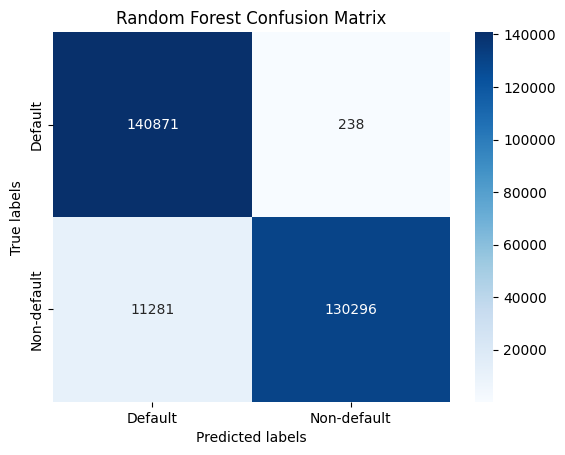

<Figure size 640x480 with 0 Axes>

In [20]:
fig = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

# Set labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')

tick_labels = ['Default', 'Non-default']
tick_positions = [0, 1]
plt.xticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)
plt.yticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)

# Show the plot
plt.show()

plt.tight_layout()

graph = fig.get_figure()
graph.savefig(f"../results/random_forest/cm-{project_name}.png")

In [21]:
x = scaler.transform(kf_x)
y = kf_y

interpretation_model = loaded_model.fit(x, y)

with open(f"random_forest/{project_name}-interpretation.pkl", "wb") as file:
    pickle.dump(interpretation_model, file)